In [1]:
from src.mbsts.notebooks.mur_wind_prev import  get_wind_prev_pivot
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tfd = tfp.distributions
tfb = tfp.bijectors

In [3]:
ZONES = ("22Bolo", "24Ama1", "26Fanh", "27Arr1", "29Sob2", "44Milagre", "48Vale_de", "60Maravil", "61MaraviII", "68Jogui")
HIST_NUM_YEARS = 4

In [4]:
# Hourly Wind generation data with multiple time series as columns 
df = get_wind_prev_pivot(ZONES, HIST_NUM_YEARS)

In [5]:
#df contains hourly wind generation data including historical data and forecasted for each time series. I want to split the data into historical and forecasted data based now time filtering the datetimeindex. getting df_hist and df_forecast

df_hist = df.loc[df.index < pd.Timestamp.now()]
df_forecast = df.loc[df.index >= pd.Timestamp.now()]


In [6]:
tfd = tfp.distributions

In [7]:
num_timesteps, num_series = df_hist.shape
num_predictors = 5 
# def build_mbsts_model(num_timesteps, num_series, num_predictors):

In [8]:
# Example predictors
predictors = tf.Variable(tf.random.normal([num_timesteps, num_predictors]), name='predictors')

In [9]:
# Define priors for the model parameters
mu = tf.Variable(tf.zeros([num_series]), name='mu')
sigma = tfp.util.TransformedVariable(tf.eye(num_series), tfb.FillScaleTriL(), name='sigma')

In [10]:
# Trend component
# trend = tfd.Normal(loc=tf.zeros([num_timesteps, num_series]), scale=1.0, name='trend')

 # Sample from the distributions for each component
trend_dist = tfd.Normal(loc=tf.zeros([num_timesteps, num_series]), scale=1.0)
trend = trend_dist.sample()

In [11]:
# Seasonal component
# seasonality = tfd.Normal(loc=tf.zeros([num_timesteps, num_series]), scale=1.0, name='seasonality')

seasonality_dist = tfd.Normal(loc=tf.zeros([num_timesteps, num_series]), scale=1.0)
seasonality = seasonality_dist.sample()

In [12]:
# Cyclical component
# cycle = tfd.Normal(loc=tf.zeros([num_timesteps, num_series]), scale=1.0, name='cycle')
cycle_dist = tfd.Normal(loc=tf.zeros([num_timesteps, num_series]), scale=1.0)
cycle = cycle_dist.sample()

In [13]:
# Regression component
# regression_coefficients = tfd.Normal(loc=tf.zeros([num_series, num_predictors]), scale=1.0,name='regression_coefficients')
# predictors = tf.Variable(tf.zeros([num_timesteps, num_predictors]), name='predictors')

regression_coefficients_dist = tfd.Normal(loc=tf.zeros([num_series, num_predictors]), scale=1.0)
regression_coefficients = regression_coefficients_dist.sample()


In [14]:
# Observation model
observation_model = (
        mu 
        + trend 
        + seasonality 
        + cycle 
        + tf.linalg.matmul(predictors, regression_coefficients, transpose_b=True)
)

In [30]:
# Ensure the outputs are between 0 and 1 using a sigmoid activation
observation_model = 0.2 + 0.7 * tf.sigmoid(observation_model)

In [31]:
# Add noise
model = tfd.MultivariateNormalTriL(loc=observation_model, scale_tril=sigma)

    # return y

In [32]:
# Define the log probability of the model
log_model_prob = model.log_prob(df_hist.values)

InvalidArgumentError: {{function_node __wrapped__Sub_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [34734,10] vs. [35073,10] [Op:Sub] name: 

### Fit the model using MCMC

In [33]:
def target_log_prob_fn(log_model=log_model_prob):
    # return tf.reduce_sum(model.log_prob(observations))
    return log_model

In [34]:
# Define the HMC transition kernel
nuts_kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_fn,
    step_size=0.1,
    num_leapfrog_steps=3
)

In [35]:
# Run the MCMC chain
num_results = 500
num_burnin_steps = 300


In [36]:
@tf.function
def run_chain(model, num_results, num_burnin_steps, nuts_kernel):
    # Initial state for MCMC
    initial_state = model.trainable_variables

    return tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_state,
        kernel=nuts_kernel,
        trace_fn=lambda current_state, kernel_results: kernel_results.is_accepted
    )

In [37]:
# Execute the MCMC chain
samples, is_accepted = run_chain(model, num_results, num_burnin_steps, nuts_kernel)

In [39]:
# Function to generate scenarios for the next 3 months (approx. 3 * 30 * 24 hours)
def generate_scenarios(model, num_scenarios=3, horizon=15*24):
    scenarios = []
    for _ in range(num_scenarios):
        scenario = model.sample(horizon).numpy()
        scenarios.append(scenario)
    return np.array(scenarios)

# Generate scenarios
scenarios = generate_scenarios(model)

In [ ]:
# Ensure all generated values are between 0 and 1
assert np.all((scenarios >= 0) & (scenarios <= 1)), "Generated scenarios contain values outside [0, 1] range"

In [ ]:
# Function to check covariance similarity
def check_covariance_similarity(historical_data, scenarios):
    historical_cov = np.cov(historical_data, rowvar=False)
    scenario_cov = np.cov(scenarios.reshape(-1, num_series), rowvar=False)
    return np.allclose(historical_cov, scenario_cov, atol=0.01)  # Adjust tolerance as needed

# Check covariance similarity
covariance_similar = check_covariance_similarity(df_hist.values, scenarios)

print("Covariance matrices similarity check:", covariance_similar)

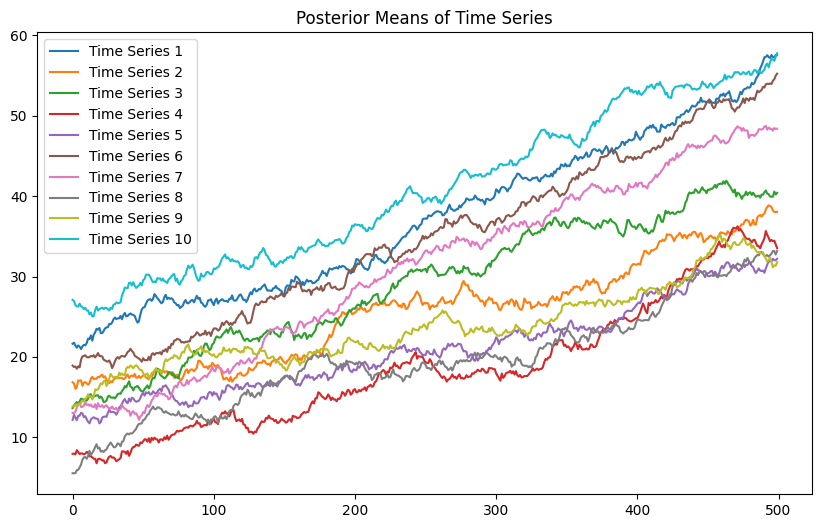

In [167]:
# Extract posterior means
posterior_mu = samples[0].numpy()

plt.figure(figsize=(10, 6))
for i in range(num_series):
    plt.plot(posterior_mu[:, i], label=f'Time Series {i+1}')
plt.legend()
plt.title('Posterior Means of Time Series')
plt.show()
